In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 使用 transforms 來將圖像轉換為張量並將像素值歸一化到 [0, 1]：
transform  = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root = './data', 
    train = True, 
    transform = transform, 
    download = True
)

test_dataset = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    transform = transform, 
    download = True
)

#為了更方便地處理數據集，可以使用 DataLoader，這樣可以在訓練時分批讀取數據：
train_dataset = datasets.FashionMNIST(root='data', train = True, transform=transform, download = True)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

test_dataset = datasets.FashionMNIST(root = 'data', train = False, transform = transform, download = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)


In [51]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2_mu = nn.Linear(512, 2)
        self.fc2_logvar = nn.Linear(512, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

In [52]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 784)
    
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z

In [53]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [54]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 784))
        z = reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar
    
    # loss = reconstruction + KL Divergence
    def lossfunction(self, recon_x, x, mu, logvar):
        # recon_x is the output of decoder, x.view is the flattened version of original image(28 * 28)
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction = 'sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [56]:
def train(epoch):
    model.train()
    train_loss = 0
    # batch_idx is the index of the current batch, data is the input data, _ usually represents labels,
    # but we don't need labels here
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # celaring the cumulative batch
        optimizer.zero_grad()
        # throw data into model, model outputs three values 1.reconstructed data, mu, logvar
        recon_batch, mu, logvar = model(data)
        # calculate loss
        loss = model.lossfunction(recon_batch, data, mu, logvar)
        # do back propogation
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.6f}')

In [57]:
def test(epoch):
    model.eval()
    test_loss  = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.lossfunction(recon_batch, data, mu, logvar)
            test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.6f}')

In [58]:
for epoch in range(1, 11):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 551.485168
Train Epoch: 1 [6400/60000 (11%)]	Loss: 304.652649
Train Epoch: 1 [12800/60000 (21%)]	Loss: 276.518097
Train Epoch: 1 [19200/60000 (32%)]	Loss: 295.007690
Train Epoch: 1 [25600/60000 (43%)]	Loss: 272.580292
Train Epoch: 1 [32000/60000 (53%)]	Loss: 279.573547
Train Epoch: 1 [38400/60000 (64%)]	Loss: 282.425842
Train Epoch: 1 [44800/60000 (75%)]	Loss: 277.789398
Train Epoch: 1 [51200/60000 (85%)]	Loss: 281.809296
Train Epoch: 1 [57600/60000 (96%)]	Loss: 280.971313
====> Epoch: 1 Average loss: 282.977427
====> Test set loss: 273.302869
Train Epoch: 2 [0/60000 (0%)]	Loss: 259.749542
Train Epoch: 2 [6400/60000 (11%)]	Loss: 271.975769
Train Epoch: 2 [12800/60000 (21%)]	Loss: 279.351776
Train Epoch: 2 [19200/60000 (32%)]	Loss: 260.492371
Train Epoch: 2 [25600/60000 (43%)]	Loss: 299.672394
Train Epoch: 2 [32000/60000 (53%)]	Loss: 287.496521
Train Epoch: 2 [38400/60000 (64%)]	Loss: 281.339539
Train Epoch: 2 [44800/60000 (75%)]	Loss: 244.735031
Trai

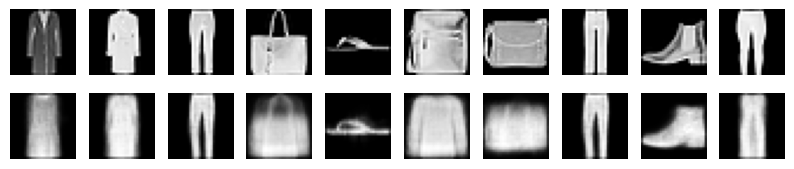

In [59]:
def show_reconstructed_images(model, num_images = 10):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon_batch, _, _ = model(data)
            if i == 0:
                comparison = torch.cat([data[:num_images], recon_batch.view(64, 1, 28, 28)[:num_images]])
                break
    fig, axes = plt.subplots(2, num_images, figsize = (10, 2))
    for k in range(num_images):
        axes[0, k].imshow(comparison[k].cpu().numpy().squeeze(), cmap='gray')
        axes[1, k].imshow(comparison[num_images + k].cpu().numpy().squeeze(), cmap='gray')
        axes[0, k].axis('off')
        axes[1, k].axis('off')
    plt.show()

show_reconstructed_images(model)

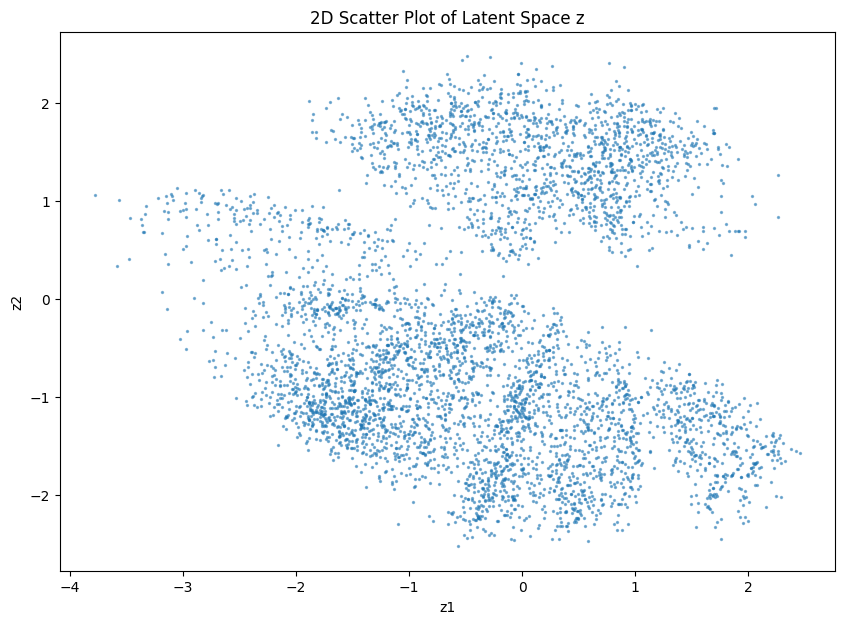

In [60]:
def plot_latent_space(model, num_points = 5000):
    model.eval()
    z_list = []
    with torch.no_grad():
        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            mu, logvar = model.encoder(data.view(-1, 784))
            z = reparameterize(mu, logvar)
            z_list.append(z.cpu().numpy())
            if len(z_list) * train_loader.batch_size >= num_points:
                break
    
    z_array = np.concatenate(z_list)[:num_points]
    plt.figure(figsize=(10, 7))
    plt.scatter(z_array[:, 0], z_array[:, 1], s=2, alpha=0.5)
    plt.title('2D Scatter Plot of Latent Space z')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()

plot_latent_space(model)

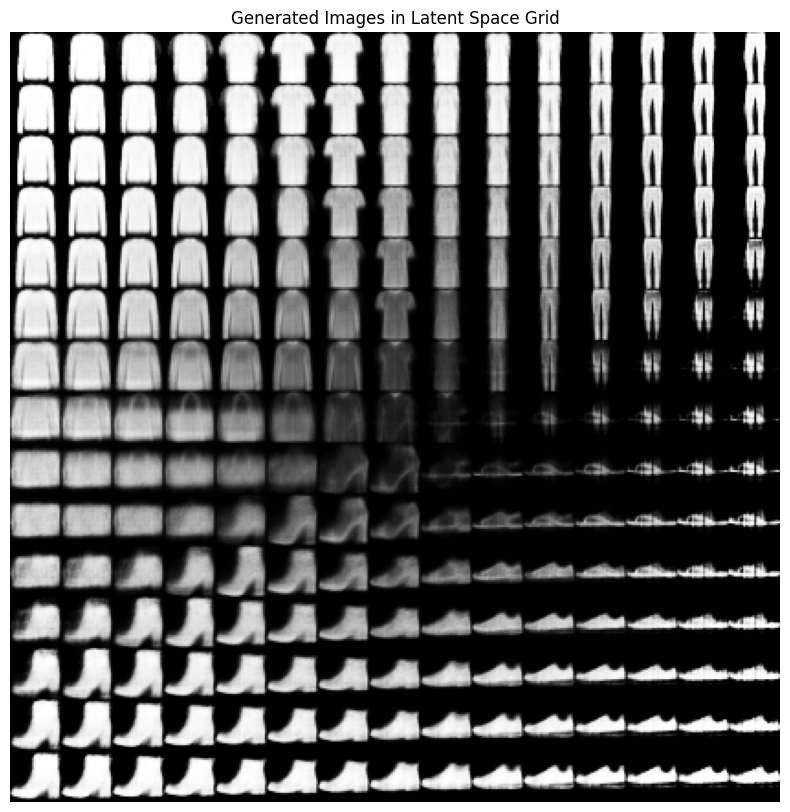

In [61]:
def generate_grid_images(model, grid_size=15):
    model.eval()
    figure = np.zeros((28 * grid_size, 28 * grid_size))
    grid_x = np.linspace(-3, 3, grid_size)
    grid_y = np.linspace(-3, 3, grid_size)
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
                recon_x = model.decoder(z)
                digit = recon_x.view(28, 28).cpu().numpy()
                figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.title('Generated Images in Latent Space Grid')
    plt.axis('off')
    plt.show()

generate_grid_images(model)